In [1]:
#cd "Documents/MastersAppliedAIDeakin/SIT720_Machine_Learning/Assignment_Project//"
#Change to data location

In [2]:
import pandas as pd
from IPython.display import display, clear_output
import numpy as np
from sklearn.utils import shuffle

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

from statistics import mode
from statistics import mean

#### 1. Read the article and reproduce the results presented in Table-4 using Python modules and packages (including your own script or customised codes). Write a report summarising the dataset, used ML methods, experiment protocol and results including variations, if any. During reproducing the results: <br>
i) you should use the same set of features used by the authors.<br>
ii) you should use the same classifier with exact parameter values.<br>
iii) you should use the same training/test splitting approach as used by the authors.<br>
iv) you should use the same pre/post processing, if any, used by the authors.<br>
v) you should report the same performance metrics as shown in Table-4.

#### Authors use only clinical features and drop the 'time' column for table 4 results

In [3]:
#Load data
df_heart = pd.read_csv("heart_failure_clinical_records_dataset.csv")
display(df_heart)
print (df_heart.dtypes)
#Preprocess 
#Using only clinical features as reported in article, dropping time
df_heart.drop(columns=['time'], inplace=True)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object


#### Specifying the models which need hyper param tuning

In [4]:
#models used in code, same order as in the article, 
#True denotes hyper param optimiztion required, false not required
###########DO NOT CHANGE THIS DICT: just used to check which models need hyper param tuning##########
model_dict = {"RF": False, "DT": False, "GradBoost": False, "LinearReg": False, 
              "OneR": False, "ANN": True, "NB": False, 
              "SVM_R": True, "SVM_L": True, "KNN": True}

#models_to_run list, the code is executed only for models in this list
#If need to run single or not full models just init a list with those model(s)
#eg: models_to_run = ["RF"], will only run Random Forest model

models_to_run = ["RF", "DT", "GradBoost", "LinearReg", "OneR", "ANN", "NB", "SVM_R", "SVM_L", "KNN"]
#models_to_run = ["SVM_R"]

#Total number of times each model is run
exc_range = 100

#Param lists for models which require hyper param tuning, used refering to R implementation from git
#https://github.com/davidechicco/cardiovascular_heart_disease
svmCList = [0.001, 0.01, 0.1, 1, 10]
annHiddenUnitsList = [5, 10, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
annHiddenLayerList = [1, 2, 3, 4, 5]
maxK = 100
knnKList = range(1, maxK+1)

#Linear regression Threshold for classification as used in git R code
lrThreshold = 0.5

#Lists for storing best params grid search over all runs, to be used in finding best values frequency
bestKList = []
bestCListRBF = []
bestCListLinear = []
bestHUList = []
bestHLList = []

#DF to store accuracy stats for all models
df_model_result = pd.DataFrame(columns = ['Method', 'MCC', 'F1Score', 'Accuracy', 'TPR', 'TNR', 'PR_AUC', 'ROC_AUC'])

In [5]:
#Utility function to calculate Matthews corrcoef [Similar to sklearn, 
#not used sklearn's because of 0 division warning], 
#results are similar from both the functions [Validated on all the classifiers]

def CalcMCC(tn, fp, fn, tp):
    if 0 in [tn, fp, fn, tp]:
        return 0.0 #If any of the 4 params is 0, MCC turns out to be 0
    else:
        return ((tp * tn) - (fp * fn))/np.sqrt(((tp + fp)*(tp + fn))*(tn + fp)*(tn + fn))

#### Grid search and prediction flow: 
1 - Check if model needs hyper param tuning <br>
2 - If yes then run 100 times <br>
    &emsp;- Split in 60, 20, 20 [Train, Validation, Test] <br>
    &emsp;- do param tuning for each run  <br>
    &emsp;- Use best hyper param to predict <br>
3 - If not then run 100 times: <br>
    &emsp;- Split in 80 - 20 ratio [Train, Test] <br>
    &emsp;- Predict directly on test set  <br>
4 - Store results for each model [mean for all 100 runs per model]<br>
#### Blocks after prediction and grid search block
5 - Compare reported hyperparam for models requiring hyper param tuning<br>
6 - Compare reported model results for each model<br>

In [6]:
#Grid Search and prediction block

#for model in model_dict:
for model in models_to_run:
    #Lists for storing prediction results for each model over all runs
    #This is used to calculate mean score for each performance criteria
    mccTestList = [] 
    f1scoreList = []
    accuracyList = []
    tpRateList = []
    tnRateList = []
    pr_aucTestList = []
    roc_aucTestList = []
    
    for exec_itr in range(exc_range):
        
        #Shuffle data
        df_heart = shuffle(df_heart)
        df_heart.reset_index(inplace=True, drop=True)
        X, Y = df_heart.loc[:, df_heart.columns != 'DEATH_EVENT'], df_heart["DEATH_EVENT"]
        
        clf = None
        
        #check if model needs hyper param
        #Models where hyper parameter tuning is required
        if (model_dict[model]):            
            #Split into train, val and test [60, 20, 20]
            trainSetX, valSetX, testSetX = np.split(X, [int(.6*len(X)), int(.8*len(X))])
            trainSetY, valSetY, testSetY = np.split(Y, [int(.6*len(Y)), int(.8*len(Y))])

            mccValList = [] #used to find best param from grid search
            tempParamList = [] #used to store param(s) for every grid search iteration
   
            if model == "ANN":
                for hl in annHiddenLayerList:
                    for hu in annHiddenUnitsList:
                        # Params from git R code
                        clf = MLPClassifier(hidden_layer_sizes=(hl, hu), max_iter = 500, 
                                            alpha = 0.5,
                                            learning_rate_init = 0.01,
                                            solver = 'sgd')
                        clf.fit(trainSetX, trainSetY)
                        predValY = clf.predict(valSetX)

                        tnVal, fpVal, fnVal, tpVal = confusion_matrix(valSetY, predValY).ravel()
                        mccVal = CalcMCC(tnVal, fpVal, fnVal, tpVal)
                        mccValList.append(mccVal)
                        tempParamList.append((hl,hu))                       
                
                #load with best hl and hu
                bestMCC = max(mccValList)
                bestHL, bestHU = tempParamList[mccValList.index(bestMCC)]
                clf = MLPClassifier(hidden_layer_sizes=(bestHL, bestHU), max_iter = 500, 
                                    alpha = 0.5,
                                    learning_rate_init = 0.01,
                                    solver = 'sgd')
                clf.fit(trainSetX, trainSetY)
                
                bestHLList.append(bestHL)
                bestHUList.append(bestHU)
                
            if model == "SVM_L":
                #Do grid search using MCC for best C
                for c in svmCList:
                    clf = make_pipeline(StandardScaler(), svm.LinearSVC(C = c, dual=False))
                    clf.fit(trainSetX, trainSetY)
                    predValY = clf.predict(valSetX)

                    tnVal, fpVal, fnVal, tpVal = confusion_matrix(valSetY, predValY).ravel()
                    mccVal = CalcMCC(tnVal, fpVal, fnVal, tpVal)
                    mccValList.append(mccVal)
                    tempParamList.append(c)

                #load with best C
                bestMCC = max(mccValList)
                bestC = tempParamList[mccValList.index(bestMCC)]
                
                clf = make_pipeline(StandardScaler(), svm.LinearSVC(C = bestC, dual=False))
                clf.fit(trainSetX, trainSetY)
                
                bestCListLinear.append(bestC)
                
            if model == "SVM_R":
                #Do grid search using MCC for best C
                for c in svmCList:
                    clf = svm.SVC(kernel='rbf', C=c)
                    clf.fit(trainSetX, trainSetY)
                    predValY = clf.predict(valSetX)
                    
                    tnVal, fpVal, fnVal, tpVal = confusion_matrix(valSetY, predValY).ravel()
                    mccVal = CalcMCC(tnVal, fpVal, fnVal, tpVal)
                    mccValList.append(mccVal)   
                    tempParamList.append(c)

                #load with best C
                bestMCC = max(mccValList)
                bestC = tempParamList[mccValList.index(bestMCC)]
                
                clf = svm.SVC(kernel='rbf', C=bestC)
                clf.fit(trainSetX, trainSetY)
                
                bestCListRBF.append(bestC)


                
            if model == "KNN":
                #Do grid search using MCC for best K
                for k in knnKList:
                    clf = KNeighborsClassifier(n_neighbors=k)
                    clf.fit(trainSetX, trainSetY)
                    predValY = clf.predict(valSetX)

                    tnVal, fpVal, fnVal, tpVal = confusion_matrix(valSetY, predValY).ravel()
                    #mccVal = matthews_corrcoef(valSetY, predValY)
                    mccVal = CalcMCC(tnVal, fpVal, fnVal, tpVal)
                    mccValList.append(mccVal)
                    #tempParamList.append(k) #not needed as mccVal is stored on (K-1)th index

                #load with best param
                bestMCC = max(mccValList)
                bestK = mccValList.index(bestMCC) + 1
                
                clf = KNeighborsClassifier(n_neighbors=bestK)                
                #TODO: Remove
                #clf = KNeighborsClassifier(n_neighbors=3)                
                clf.fit(trainSetX, trainSetY)
                #print ("bestK for ", model, " : ", bestK)
                bestKList.append(bestK)

            
            #########################Common part####################
            #Predict on test set using best param
            predTestY = clf.predict(testSetX)
            
            tnTest, fpTest, fnTest, tpTest = confusion_matrix(testSetY, predTestY).ravel()
            
            mccTest = CalcMCC(tnTest, fpTest, fnTest, tpTest)
            f1score = f1_score(testSetY, predTestY)
            accuracy = accuracy_score(testSetY, predTestY)
            tpRate = recall_score(testSetY, predTestY) #recall, sensitivity
            tnRate = tnTest / (tnTest + fpTest) #specificity
            
            if hasattr(clf, "decision_function"):
                precision, recall, thresholds = precision_recall_curve(testSetY, clf.decision_function(testSetX))
                roc_aucTest = roc_auc_score(testSetY, clf.decision_function(testSetX))
                
            else:
                precision, recall, thresholds = precision_recall_curve(testSetY, clf.predict_proba(testSetX)[:, 1], 
                                                                   pos_label = 1)
                roc_aucTest = roc_auc_score(testSetY, clf.predict_proba(testSetX)[:, 1])

            pr_aucTest = auc(recall, precision)
            
            mccTestList.append(mccTest)
            f1scoreList.append(f1score)
            accuracyList.append(accuracy)
            tpRateList.append(tpRate)
            tnRateList.append(tnRate)
            pr_aucTestList.append(pr_aucTest)
            roc_aucTestList.append(roc_aucTest)
            
            print ("Model: ", model, " of ", models_to_run, "\nIteration: ", exec_itr + 1, " of ", exc_range, \
                   "\nbestMCC for ", model, " after GridSearch: ", bestMCC, \
                   "\nTest Results for this iteration: ", \
                   "\nMCC score for ", model, " : ", mccTest, \
                   "\nF1 score for ", model, " : ", f1score, \
                   "\nAccuracy for ", model, " : ", accuracy, \
                   "\nTPR for ", model, " : ", tpRate, \
                   "\nTNR for ", model, " : ", tnRate, \
                   "\nPR-AUC for ", model, " : ", pr_aucTest, \
                   "\nROC-AUC for ", model, " : ", roc_aucTest)
            
        #Models where hyper param tuning is not required   
        else:
            #Split in train and test [80, 20] for models where hyper params are not tuned
            trainSetX, testSetX = np.split(X, [int(.8*len(X))])
            trainSetY, testSetY = np.split(Y, [int(.8*len(Y))])

            #Load model
            if model == "RF":
                clf = RandomForestClassifier()
                clf.fit(trainSetX, trainSetY)
                
            if model == "DT":
                clf = tree.DecisionTreeClassifier()
                clf.fit(trainSetX, trainSetY)
            
            if model == "GradBoost":
                #In repo depth for xgboost is 2 but nothing 
                clf = GradientBoostingClassifier()
                clf.fit(trainSetX, trainSetY)

            if model == "LinearReg":
                clf =  LinearRegression()
                clf.fit(trainSetX, trainSetY)

            if model == "OneR":
                #Closest to the results in the article
                #Lack of param info in code as well as article
                clf = DummyClassifier(strategy='stratified')                
                clf.fit(trainSetX, trainSetY)

            if model == "NB":
                clf = GaussianNB()
                clf.fit(trainSetX, trainSetY)
            
            #Predict on test using default param
            predTestY = clf.predict(testSetX)
            
            if model == "LinearReg":
                predTestYScores = predTestY.copy()
                #Using threshold of 0.5(lrThreshold) as mentioned in git code for linear regression
                predTestY = [1 if ele >= lrThreshold else 0 for ele in predTestY]
            
            tnTest, fpTest, fnTest, tpTest = confusion_matrix(testSetY, predTestY).ravel()
            
            mccTest = CalcMCC(tnTest, fpTest, fnTest, tpTest)
            f1score = f1_score(testSetY, predTestY)
            accuracy = accuracy_score(testSetY, predTestY)
            tpRate = recall_score(testSetY, predTestY) #recall, sensitivity
            tnRate = tnTest / (tnTest + fpTest) #specificity
            
            if hasattr(clf, "decision_function"):
                precision, recall, thresholds = precision_recall_curve(testSetY, clf.decision_function(testSetX))
                roc_aucTest = roc_auc_score(testSetY, clf.decision_function(testSetX))
            
            elif model == "LinearReg":
                precision, recall, thresholds = precision_recall_curve(testSetY, predTestYScores)
                roc_aucTest = roc_auc_score(testSetY, predTestYScores)
                
            else:
                precision, recall, thresholds = precision_recall_curve(testSetY, clf.predict_proba(testSetX)[:, 1], 
                                                                   pos_label = 1)
                roc_aucTest = roc_auc_score(testSetY, clf.predict_proba(testSetX)[:, 1])

            pr_aucTest = auc(recall, precision)
            
            mccTestList.append(mccTest)
            f1scoreList.append(f1score)
            accuracyList.append(accuracy)
            tpRateList.append(tpRate)
            tnRateList.append(tnRate)
            pr_aucTestList.append(pr_aucTest)
            roc_aucTestList.append(roc_aucTest)
            
            print ("Model: ", model, " of ", models_to_run, "\nIteration: ", exec_itr + 1, " of ", exc_range, \
                   "\nTest Results for this iteration: ", \
                   "\nMCC score for ", model, " : ", mccTest, \
                   "\nF1 score for ", model, " : ", f1score, \
                   "\nAccuracy for ", model, " : ", accuracy, \
                   "\nTPR for ", model, " : ", tpRate, \
                   "\nTNR for ", model, " : ", tnRate, \
                   "\nPR-AUC for ", model, " : ", pr_aucTest, \
                   "\nROC-AUC for ", model, " : ", roc_aucTest)

            #Store results for model
        clear_output(wait=True)
    
    meanMcc = mean(mccTestList)
    meanF1 = mean(f1scoreList)
    meanAccuracy = mean(accuracyList)
    meanTPR = mean(tpRateList)
    meanTNR = mean(tnRateList)
    meanPR_AUC = mean(pr_aucTestList)
    meanROC_AUC = mean(roc_aucTestList)
    
    print ("Model: ", model, " of ", models_to_run, "\nIteration: ", exec_itr + 1, " of ", exc_range, \
                   "\nMean Test Results for 100 iteration: ", \
                   "\nMean MCC score for ", model, " : ", meanMcc, \
                   "\nMean F1 score for ", model, " : ", meanF1, \
                   "\nMean Accuracy for ", model, " : ", meanAccuracy, \
                   "\nMean TPR for ", model, " : ", meanTPR, \
                   "\nMean TNR for ", model, " : ", meanTNR, \
                   "\nMean PR-AUC for ", model, " : ", meanPR_AUC, \
                   "\nMean ROC-AUC for ", model, " : ", meanROC_AUC)
    
    #store results of models
    df_model_result = df_model_result.append({"Method": model, "MCC": meanMcc, "F1Score": meanF1, 
                                              "Accuracy": meanAccuracy, "TPR": meanTPR, 
                                              "TNR": meanTNR, "PR_AUC": meanPR_AUC, 
                                              "ROC_AUC": meanROC_AUC}, 
                                             ignore_index = True)


Model:  KNN  of  ['RF', 'DT', 'GradBoost', 'LinearReg', 'OneR', 'ANN', 'NB', 'SVM_R', 'SVM_L', 'KNN'] 
Iteration:  100  of  100 
Mean Test Results for 100 iteration:  
Mean MCC score for  KNN  :  -0.000416760953795677 
Mean F1 score for  KNN  :  0.13699637929534778 
Mean Accuracy for  KNN  :  0.6341666666666667 
Mean TPR for  KNN  :  0.10154768659422718 
Mean TNR for  KNN  :  0.8879109289720498 
Mean PR-AUC for  KNN  :  0.3468175232899102 
Mean ROC-AUC for  KNN  :  0.4997994212398738


#### Comparing hyper params reported in article vs experimentally found

In [7]:
#Hyper param comparison block
#Reported vs Experimental[Following same process] 

if ("SVM_R" in models_to_run):
    bestCAbsRBF = mode(bestCListRBF)
    print ("Best C for SVM RBF: ", bestCAbsRBF, "Occurs ", bestCListRBF.count(bestCAbsRBF), " times out of ", exc_range)

if ("SVM_L" in models_to_run):
    bestCAbsL = mode(bestCListLinear)
    print ("Best C for SVM linear: ", bestCAbsL, "Occurs ", bestCListLinear.count(bestCAbsL), " times out of ", exc_range)

if ("KNN" in models_to_run):
    bestKAbs = mode(bestKList)
    print ("Best K for KNN: ", bestKAbs, "Occurs ", bestKList.count(bestKAbs), " times out of ", exc_range)
    
if ("ANN" in models_to_run):
    bestHUAbs = mode(bestHUList)
    bestHLAbs = mode(bestHLList)
    print ("Best Hidden units for ANN: ", bestHUAbs, "Occurs ", bestHUList.count(bestHUAbs), " times out of ", exc_range)
    print ("Best Hidden layers for ANN: ", bestHLAbs, "Occurs ", bestHLList.count(bestHLAbs), " times out of ", exc_range)


Best C for SVM RBF:  0.001 Occurs  98  times out of  100
Best C for SVM linear:  0.001 Occurs  51  times out of  100
Best K for KNN:  2 Occurs  18  times out of  100
Best Hidden units for ANN:  5 Occurs  99  times out of  100
Best Hidden layers for ANN:  1 Occurs  99  times out of  100


In [8]:
#Counting params mentioned in article
print("KNN K = 3: ",bestKList.count(3), "runs out of 100")
print("SVM C-Radial = 10: ",bestCListRBF.count(10), "runs out of 100")
print("SVM C-Linear = 0.1: ",bestCListLinear.count(0.1), "runs out of 100")
print("ANN Hidden Layer = 1: ",bestHLList.count(1), "runs out of 100")
print("ANN Hidden Units = 100: ",bestHUList.count(100), "runs out of 100")



KNN K = 3:  5 runs out of 100
SVM C-Radial = 10:  2 runs out of 100
SVM C-Linear = 0.1:  18 runs out of 100
ANN Hidden Layer = 1:  99 runs out of 100
ANN Hidden Units = 100:  0 runs out of 100


#### Results table after replicating process mentioned in the article

In [9]:
#results comparison block
#Reported vs Experimental [Following same process]
display(df_model_result.style.highlight_max(color = 'lightblue', axis = 0))

,Method,MCC,F1Score,Accuracy,TPR,TNR,PR_AUC,ROC_AUC
0,RF,0.353597,0.520677,0.735333,0.471933,0.856388,0.616185,0.788918
1,DT,0.284963,0.509692,0.687667,0.516914,0.767278,0.592912,0.642096
2,GradBoost,0.326995,0.511913,0.714833,0.471364,0.836970,0.577609,0.744968
3,LinearReg,0.334194,0.484158,0.734000,0.402638,0.895496,0.619495,0.765479
4,OneR,0.002387,0.308327,0.563500,0.322117,0.675742,0.423965,0.503523
5,ANN,0.000000,0.093569,0.610833,0.190000,0.810000,0.661917,0.500000
6,NB,0.212189,0.334363,0.703000,0.235043,0.933668,0.564273,0.729500
7,SVM_R,0.000000,0.000000,0.682500,0.000000,0.999291,0.327732,0.485491
8,SVM_L,0.360023,0.520050,0.737833,0.447939,0.880284,0.630453,0.770463
9,KNN,-0.000417,0.136996,0.634167,0.101548,0.887911,0.346818,0.499799


#### 2. Design and develop your own ML solution for this problem. The proposed solution should be different from all approaches mentioned in the provided article. This does not mean that you must have to choose a new ML algorithm. You can develop a novel solution by changing the feature selection approach or parameter optimisations process of used ML methods or using different ML methods or different combinations of them. This means, the proposed system should be substantially different from the methods presented in the article but not limited to only change of ML methods. Compare the result with reported methods in the article. Write a technical report summarising your solution design and outcomes. The report should include: <br>
i) Motivation behind the proposed solution.<br>
ii) How the proposed solution is different from existing ones.<br>
iii) Detail description of the model including all parameters so that any reader can implement your model.<br>
iv) Description of experimental protocol.<br>
v) Evaluation metrics.<br>
vi) Present results using tables and graphs.<br>
vii) Compare and discuss results with respect to existing literatures.<br>
viii) Appropriate references (IEEE numbered).<br>

In [10]:
#Additional imports
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay


In [11]:
#check for duplicates
df_res = pd.read_csv("heart_failure_clinical_records_dataset.csv")
print (df_res[df_res.isnull().any(axis=1)].shape) #null check
print(df_res.shape)
df_res.drop_duplicates()
print(df_res.shape)
print (df_res.dtypes)

(0, 13)
(299, 13)
(299, 13)
age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object


In [12]:
#Explore original dataframe
display(df_res.describe())

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [13]:
#Explore death vs no death dataframe
#Time seems important
no_death_df = df_res.loc[(df_res['DEATH_EVENT'] == 0)]
death_df = df_res.loc[(df_res['DEATH_EVENT'] != 0)]
display(no_death_df.describe())
display(death_df.describe())


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.0
mean,58.761906,0.408867,540.054187,0.418719,40.266010,0.325123,266657.489901,1.184877,137.216749,0.650246,0.325123,158.339901,0.0
std,10.637890,0.492840,753.799572,0.494569,10.859963,0.469579,97531.202283,0.654083,3.982923,0.478071,0.469579,67.742872,0.0
min,40.000000,0.000000,30.000000,0.000000,17.000000,0.000000,25100.000000,0.500000,113.000000,0.000000,0.000000,12.000000,0.0
25%,50.000000,0.000000,109.000000,0.000000,35.000000,0.000000,219500.000000,0.900000,135.500000,0.000000,0.000000,95.000000,0.0
50%,60.000000,0.000000,245.000000,0.000000,38.000000,0.000000,263000.000000,1.000000,137.000000,1.000000,0.000000,172.000000,0.0
75%,65.000000,1.000000,582.000000,1.000000,45.000000,1.000000,302000.000000,1.200000,140.000000,1.000000,1.000000,213.000000,0.0
max,90.000000,1.000000,5209.000000,1.000000,80.000000,1.000000,850000.000000,6.100000,148.000000,1.000000,1.000000,285.000000,0.0


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.00000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.0
mean,65.215281,0.479167,670.197917,0.416667,33.468750,0.40625,256381.044792,1.835833,135.375000,0.645833,0.312500,70.885417,1.0
std,13.214556,0.502188,1316.580640,0.495595,12.525303,0.49371,98525.682856,1.468562,5.001579,0.480771,0.465946,62.378281,0.0
min,42.000000,0.000000,23.000000,0.000000,14.000000,0.00000,47000.000000,0.600000,116.000000,0.000000,0.000000,4.000000,1.0
25%,55.000000,0.000000,128.750000,0.000000,25.000000,0.00000,197500.000000,1.075000,133.000000,0.000000,0.000000,25.500000,1.0
50%,65.000000,0.000000,259.000000,0.000000,30.000000,0.00000,258500.000000,1.300000,135.500000,1.000000,0.000000,44.500000,1.0
75%,75.000000,1.000000,582.000000,1.000000,38.000000,1.00000,311000.000000,1.900000,138.250000,1.000000,1.000000,102.250000,1.0
max,95.000000,1.000000,7861.000000,1.000000,70.000000,1.00000,621000.000000,9.400000,146.000000,1.000000,1.000000,241.000000,1.0


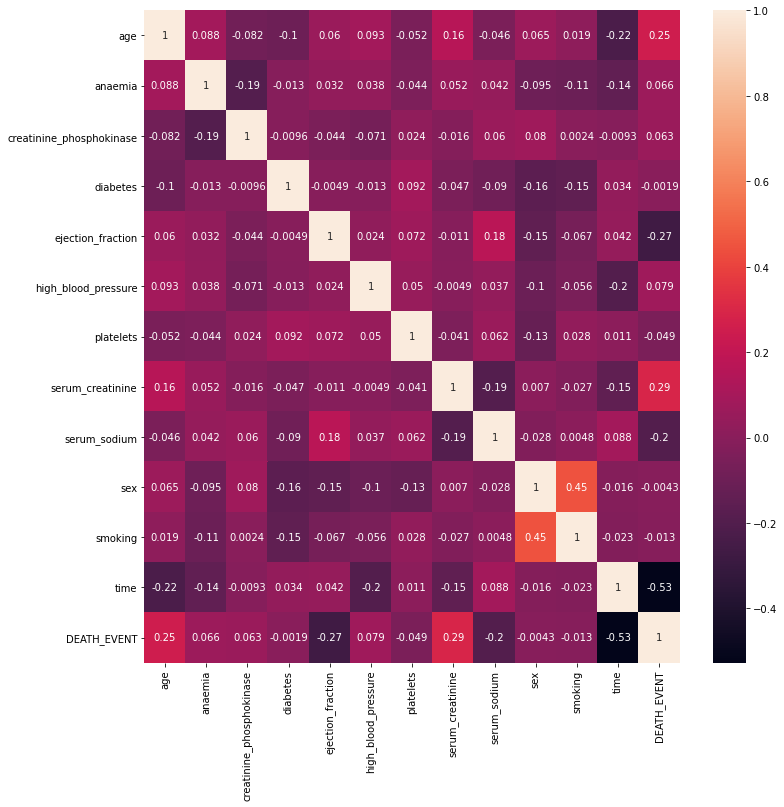

In [14]:
#Check correlation between features, age and serum_creatinine are top two
corrMatrix = df_res.corr()
plt.figure(figsize = (12,12))
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [15]:
#Grid search block
#Selectin out of 100 times loop for efficiency 
Xx, Yy = df_res.loc[:, df_res.columns != 'DEATH_EVENT'], df_res["DEATH_EVENT"]

x_train, x_test, y_train, y_test = train_test_split(Xx, Yy, stratify=Yy, test_size=0.2)

mccTestList = [] 
f1scoreList = []
accuracyList = []
tpRateList = []
tnRateList = []
pr_aucTestList = []
roc_aucTestList = []

sc = StandardScaler().fit(x_train)
x_train = sc.transform(x_train)

clfRF = RandomForestClassifier()
clfSVM = svm.SVC(kernel= 'rbf', max_iter = 1000, probability=True)
clfVoting = VotingClassifier(estimators=[('svm', clfSVM), ('rf', clfRF)], 
                                 voting='soft')

hyperparamsVoting = {'rf__max_depth': np.arange(10, 50, 10).tolist(), 
                     'rf__n_estimators': np.arange(10, 500, 50).tolist(), 
                     'rf__criterion': ['entropy', 'gini'],
                     'svm__C': svmCList}

grid = GridSearchCV(estimator=clfVoting, param_grid=hyperparamsVoting, cv=5,
                    scoring='recall', n_jobs = 4)

grid.fit(x_train, y_train)
print (grid.best_params_)
best_depth = grid.best_params_['rf__max_depth']
best_nEstimators = grid.best_params_['rf__n_estimators']
best_criterion = grid.best_params_['rf__criterion']
best_SVMC = grid.best_params_['svm__C']

{'rf__criterion': 'gini', 'rf__max_depth': 40, 'rf__n_estimators': 160, 'svm__C': 0.001}


In [16]:
#Prediction Block
#execute 100 times and report same params for fair comparison
#Maintaining ratio in split so that the results are balanced

clfRF = RandomForestClassifier(n_estimators= best_nEstimators, criterion = best_criterion)
clfSVM = svm.SVC(kernel= 'rbf',C=best_SVMC, max_iter=1000, probability=True)
clfVoting = VotingClassifier(estimators=[('svm', clfSVM), ('rf', clfRF)], 
                                 voting='soft')

for exc in range(100):
    x_train, x_test, y_train, y_test = train_test_split(Xx, Yy, stratify=Yy, test_size=0.2)
    sc = StandardScaler().fit(x_train)
    x_train = sc.transform(x_train)
    x_test = sc.transform(x_test)
    
    clfVoting.fit(x_train, y_train)
    
    
    
    predY = clfVoting.predict(x_test)
    
    cm = confusion_matrix(y_test, predY)
    tnTest, fpTest, fnTest, tpTest = cm.ravel()
    
    mccTest = CalcMCC(tnTest, fpTest, fnTest, tpTest)
    f1score = f1_score(y_test, predY)
    accuracy = accuracy_score(y_test, predY)
    tpRate = recall_score(y_test, predY) #recall, sensitivity
    tnRate = tnTest / (tnTest + fpTest) #specificity
    
    precision, recall, thresholds = precision_recall_curve(y_test, clfVoting.predict_proba(x_test)[:, 1], 
                                                                       pos_label = 1)
    roc_aucTest = roc_auc_score(y_test, clfVoting.predict_proba(x_test)[:, 1])
                                                                      
    
    pr_aucTest = auc(recall, precision)
    
    mccTestList.append(mccTest)
    f1scoreList.append(f1score)
    accuracyList.append(accuracy)
    tpRateList.append(tpRate)
    tnRateList.append(tnRate)
    pr_aucTestList.append(pr_aucTest)
    roc_aucTestList.append(roc_aucTest)
    model = "VotingEnsemble"
    print ("Model: Voting Ensemble", "\nIteration: ", exc + 1, " of ", exc_range, \
                   "\nTest Results for this iteration: ", \
                   "\nMCC score for ", model, " : ", mccTest, \
                   "\nF1 score for ", model, " : ", f1score, \
                   "\nAccuracy for ", model, " : ", accuracy, \
                   "\nTPR for ", model, " : ", tpRate, \
                   "\nTNR for ", model, " : ", tnRate, \
                   "\ncm for ", model, " : ", cm, \
                   "\nPR-AUC for ", model, " : ", pr_aucTest, \
                   "\nROC-AUC for ", model, " : ", roc_aucTest)
    clear_output(wait=True)

meanMcc = mean(mccTestList)
meanF1 = mean(f1scoreList)
meanAccuracy = mean(accuracyList)
meanTPR = mean(tpRateList)
meanTNR = mean(tnRateList)
meanPR_AUC = mean(pr_aucTestList)
meanROC_AUC = mean(roc_aucTestList)

df_model_result = df_model_result.append({"Method": "VotingEnsemble", "MCC": meanMcc, "F1Score": meanF1, 
                                              "Accuracy": meanAccuracy, "TPR": meanTPR, 
                                              "TNR": meanTNR, "PR_AUC": meanPR_AUC, 
                                              "ROC_AUC": meanROC_AUC}, 
                                             ignore_index = True)


Model: Voting Ensemble 
Iteration:  100  of  100 
Test Results for this iteration:  
MCC score for  VotingEnsemble  :  0.5378690629011553 
F1 score for  VotingEnsemble  :  0.6842105263157895 
Accuracy for  VotingEnsemble  :  0.8 
TPR for  VotingEnsemble  :  0.6842105263157895 
TNR for  VotingEnsemble  :  0.8536585365853658 
cm for  VotingEnsemble  :  [[35  6]
 [ 6 13]] 
PR-AUC for  VotingEnsemble  :  0.7394166851899779 
ROC-AUC for  VotingEnsemble  :  0.8536585365853658


In [17]:
#Comaprison with existing methods
display(df_model_result.style.highlight_max(color = 'lightblue', axis = 0))


,Method,MCC,F1Score,Accuracy,TPR,TNR,PR_AUC,ROC_AUC
0,RF,0.353597,0.520677,0.735333,0.471933,0.856388,0.616185,0.788918
1,DT,0.284963,0.509692,0.687667,0.516914,0.767278,0.592912,0.642096
2,GradBoost,0.326995,0.511913,0.714833,0.471364,0.836970,0.577609,0.744968
3,LinearReg,0.334194,0.484158,0.734000,0.402638,0.895496,0.619495,0.765479
4,OneR,0.002387,0.308327,0.563500,0.322117,0.675742,0.423965,0.503523
5,ANN,0.000000,0.093569,0.610833,0.190000,0.810000,0.661917,0.500000
6,NB,0.212189,0.334363,0.703000,0.235043,0.933668,0.564273,0.729500
7,SVM_R,0.000000,0.000000,0.682500,0.000000,0.999291,0.327732,0.485491
8,SVM_L,0.360023,0.520050,0.737833,0.447939,0.880284,0.630453,0.770463
9,KNN,-0.000417,0.136996,0.634167,0.101548,0.887911,0.346818,0.499799


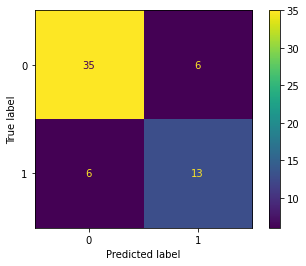

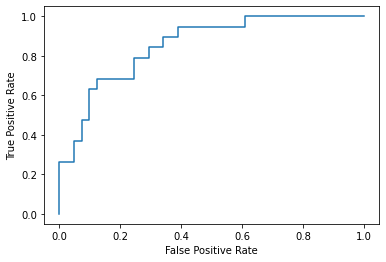

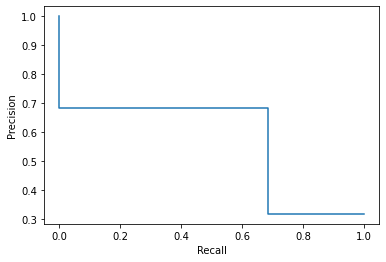

In [18]:
#displaying for final run, to vizualize results distibution
cm_display = ConfusionMatrixDisplay(cm).plot()
fpr, tpr, _ = roc_curve(y_test, clfVoting.predict_proba(x_test)[:, 1], pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
precision, recall, _ = precision_recall_curve(y_test, predY)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.show()